# Modeling
in this project I'm completing step 5 of my capstone project where I need to:

Build two to three different models and identify the best one.

Fit your models with a training dataset

Review model outcomes — Iterate over additional models as needed

Identify the final model that you think is the best model for this project



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
df = pd.read_excel(r'/Users/carlriemann/Documents/GitHub/Capstone-Two-Modeling/data_nba.xlsx')

In [3]:
df.shape

(2851, 30)

In [4]:
print(df.columns)

Index(['Player', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Tm', 'Season', 'Pos'],
      dtype='object')


In [5]:
print(df.dtypes)

Player     object
Age         int64
G           int64
GS          int64
MP        float64
FG        float64
FGA       float64
FG%       float64
3P        float64
3PA       float64
3P%       float64
2P        float64
2PA       float64
2P%       float64
eFG%      float64
FT        float64
FTA       float64
FT%       float64
ORB       float64
DRB       float64
TRB       float64
AST       float64
STL       float64
BLK       float64
TOV       float64
PF        float64
PTS       float64
Tm         object
Season     object
Pos        object
dtype: object


In [6]:
#add ratings and aggregated measures
df['Defensive_Rating'] = df['DRB'] + df['BLK'] + df['STL']
df['Offensive_Rating'] = df['PTS'] + df['AST'] + (df['FG'] * 2) + (df['3P'] * 3) + df['FT']
df['TS%'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))
df['Simplified_PER'] = (df['PTS'] + df['TRB'] + df['AST'] + df['STL'] + df['BLK'] - (df['FGA'] - df['FG']) - (df['FTA'] - df['FT']) - df['TOV']) / df['MP']

In [7]:
#changing seasons format from 2019-2020 to only 2019
df['Season'] = df['Season'].apply(lambda x: x.split('-')[0])

# converting season to numeric data
df['Season'] = df['Season'].astype(int)

print(df['Season'].unique())

[2019 2020 2021 2022 2023]


In [8]:
#replacing Unknown player positions
most_common_pos = df['Pos'].mode()[0]
df['Pos'] = df['Pos'].replace('Unknown', most_common_pos)

In [9]:
#separate year 2023 (season2023-2024) to act as proxy to test predictions, as there is no data for the future season
test_data_2023 = df[df['Season'] == 2023]

The main goal of this step is to clean, transform, and split the data so that it is ready for training machine learning models. I want to build a Player Performance Prediction model, or a Game Impact Prediction model. On this next step I create an aggregated df. 

In [10]:
#creating an aggregated df of scores and seasons without season 2023 (season 2023 will be used as test)
df_filtered = df[df['Season'] != 2023]

#aggregate player data excluding 2023, and calculate the mean for numerical columns
player_stats = df_filtered.groupby('Player').agg({col: 'mean' for col in df_filtered.columns if df_filtered[col].dtype in ['float64', 'int64']})

#count the number of unique seasons each player appears in, excluding season 2023
player_stats['Seasons_Played'] = df_filtered.groupby('Player')['Season'].nunique()

#create columns for unique teams and positions
unique_teams = df_filtered.groupby('Player')['Tm'].agg(lambda x: ', '.join(x.unique()))
unique_positions = df_filtered.groupby('Player')['Pos'].agg(lambda x: ', '.join(x.unique()))
player_stats['Unique_Teams'] = unique_teams
player_stats['Unique_Positions'] = unique_positions

#reset index to bring 'Player' back as a column
player_stats.reset_index(inplace=True)

#check
players_multiple_teams = player_stats[player_stats['Unique_Teams'].apply(lambda x: len(x.split(', ')) > 1)]
print(players_multiple_teams)

                Player        Age      G     GS         MP        FG  \
0         Aaron Gordon  25.500000  44.00  44.00  32.250000  5.275000   
2        Aaron Holiday  24.666667  37.00  11.50  16.183333  2.233333   
5          Abdel Nader  27.000000  27.00   2.00  13.500000  1.900000   
8    Admiral Schofield  23.000000  35.50   1.50  11.750000  1.250000   
10          Al Horford  34.500000  43.75  42.25  29.600000  4.300000   
..                 ...        ...    ...    ...        ...       ...   
807       Yogi Ferrell  26.500000  26.00   0.00  15.300000  2.800000   
808      Yuta Watanabe  26.500000  18.75   1.00   8.725000  1.075000   
810       Zach Collins  23.000000  19.50   7.50  22.150000  2.800000   
812       Zach Norvell  22.000000   2.50   0.00   7.250000  0.500000   
818     Zylan Cheatham  25.000000   2.50   0.00   8.900000  0.750000   

           FGA     FG%        3P       3PA  ...        PF        PTS  \
0    11.125000  0.4755  1.225000  3.500000  ...  2.225000  14.1

In [11]:
print(player_stats.dtypes)
print(player_stats.shape)
print(df.dtypes)
print(df.shape)

Player               object
Age                 float64
G                   float64
GS                  float64
MP                  float64
FG                  float64
FGA                 float64
FG%                 float64
3P                  float64
3PA                 float64
3P%                 float64
2P                  float64
2PA                 float64
2P%                 float64
eFG%                float64
FT                  float64
FTA                 float64
FT%                 float64
ORB                 float64
DRB                 float64
TRB                 float64
AST                 float64
STL                 float64
BLK                 float64
TOV                 float64
PF                  float64
PTS                 float64
Season              float64
Defensive_Rating    float64
Offensive_Rating    float64
TS%                 float64
Simplified_PER      float64
Seasons_Played        int64
Unique_Teams         object
Unique_Positions     object
dtype: object
(819, 

In [12]:
#adding columns that represent performance ratings

player_stats['Defensive_Rating'] = player_stats['DRB'] + player_stats['BLK'] + player_stats['STL']


player_stats['Offensive_Rating'] = player_stats['PTS'] + player_stats['AST'] + (player_stats['FG'] * 2) + (player_stats['3P'] * 3) + player_stats['FT']


player_stats['TS%'] = player_stats['PTS'] / (2 * (player_stats['FGA'] + 0.44 * player_stats['FTA']))

#PER (player's per-minute performance) is a measurement created by John Hollinger's
player_stats['Simplified_PER'] = (player_stats['PTS'] + player_stats['TRB'] + player_stats['AST'] + player_stats['STL'] + player_stats['BLK']
                        - (player_stats['FGA'] - player_stats['FG']) - (player_stats['FTA'] - player_stats['FT']) - player_stats['TOV']) / player_stats['MP']

player_stats.shape

(819, 35)

In [13]:
has_nans = player_stats.isnull().values.any()
print(has_nans)

True


In [14]:
total_rows = len(player_stats)
nan_percentages = (player_stats.isnull().sum() / total_rows) * 100
print("Percentage of NaN values per column:")
print(nan_percentages)

Percentage of NaN values per column:
Player              0.000000
Age                 0.000000
G                   0.000000
GS                  0.000000
MP                  0.000000
FG                  0.000000
FGA                 0.000000
FG%                 0.000000
3P                  0.000000
3PA                 0.000000
3P%                 0.000000
2P                  0.000000
2PA                 0.000000
2P%                 0.000000
eFG%                0.000000
FT                  0.000000
FTA                 0.000000
FT%                 0.000000
ORB                 0.000000
DRB                 0.000000
TRB                 0.000000
AST                 0.000000
STL                 0.000000
BLK                 0.000000
TOV                 0.000000
PF                  0.000000
PTS                 0.000000
Season              0.000000
Defensive_Rating    0.000000
Offensive_Rating    0.000000
TS%                 1.343101
Simplified_PER      0.000000
Seasons_Played      0.000000
Unique

In [15]:
nan_rows = player_stats[player_stats['TS%'].isnull()]
print(nan_rows)

                Player   Age    G   GS   MP   FG  FGA  FG%   3P  3PA  ...  \
7           Ade Murkey  24.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   
42       Ashton Hagans  21.0  2.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  ...   
171      DeJon Jarreau  24.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   
305        J.P. Macura  24.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   
322    Jaime Echenique  24.0  1.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  ...   
327       Jalen Harris  22.0  2.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  ...   
352      Jason Preston  23.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   
353    Javin DeLaurier  23.0  1.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  ...   
682         Sam Dekker  27.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   
768         Tyler Hall  24.0  1.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  ...   
793  Wendell Moore Jr.  21.0  1.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  ...   

      PF  PTS  Season  Defensive_Rating  Offensive_Rating  TS%  \
7    0.0 

In [16]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

#Apply imputer to the 'TS%' column
player_stats['TS%'] = imputer.fit_transform(player_stats[['TS%']])

#Check if any NaNs remain
print(player_stats['TS%'].isnull().sum())

0


# Testing models for Numerical Features

# Random Forest

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#Define features and target
features = ['Age', 'G', 'GS', 'MP', 'FG%', '3P%', '2P%', 'FT%', 'Defensive_Rating', 'Offensive_Rating', 'TS%', 'Simplified_PER']
X = player_stats[features]
y = player_stats['PTS']  # Target variable

#Using imputer to resolve NaN errors and using scaler
imputer = SimpleImputer(strategy='mean') 
scaler = StandardScaler()

#Impute and scale the training data
X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#Random Forest regression
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#Validate the model
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print("Random Forest Validation MSE:", mse)

#Prepare the 2023 data for testing
test_data = df[df['Season'] == 2023][features]
test_data_imputed = imputer.transform(test_data)  # Impute the test data using the already fitted imputer
test_data_scaled = scaler.transform(test_data_imputed)  # Scale the imputed test data using the already fitted scaler
y_test = df[df['Season'] == 2023]['PTS']

#Test the model
y_test_pred = model.predict(test_data_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Random Forest Test MSE:", test_mse)

Random Forest Validation MSE: 0.30602770415399777
Random Forest Test MSE: 0.4661206294955582


# Gradient Boosting

In [18]:
from sklearn.ensemble import GradientBoostingRegressor


#initialize model
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)

#fit the model on the training data
gb_model.fit(X_train, y_train)

#Predict on the validation set
y_pred_gb_val = gb_model.predict(X_val)
mse_gb_val = mean_squared_error(y_val, y_pred_gb_val)
print("Gradient Boosting Validation MSE:", mse_gb_val)

#Predict on the test set
y_pred_gb_test = gb_model.predict(test_data_scaled)
mse_gb_test = mean_squared_error(y_test, y_pred_gb_test)
print("Gradient Boosting Test MSE:", mse_gb_test)

Gradient Boosting Validation MSE: 0.289258683176696
Gradient Boosting Test MSE: 0.4406182999368603


# Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

#start model
lr_model = LinearRegression()

#fit model on training
lr_model.fit(X_train, y_train)

#predict Validate set
y_pred_lr_val = lr_model.predict(X_val)
mse_lr_val = mean_squared_error(y_val, y_pred_lr_val)
print("Linear Regression Validation MSE:", mse_lr_val)

#predict Test set
y_pred_lr_test = lr_model.predict(test_data_scaled)
mse_lr_test = mean_squared_error(y_test, y_pred_lr_test)
print("Linear Regression Test MSE:", mse_lr_test)

Linear Regression Validation MSE: 0.22233547038612547
Linear Regression Test MSE: 0.29070533581975067


# Testing other models learned

# KNN

In [20]:
from sklearn.neighbors import KNeighborsRegressor

#start the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)

#fit the model on training
knn_model.fit(X_train, y_train)

#predict on validation set
y_pred_knn_val = knn_model.predict(X_val)
mse_knn_val = mean_squared_error(y_val, y_pred_knn_val)
print("KNN Validation MSE:", mse_knn_val)

#predict on test set
y_pred_knn_test = knn_model.predict(test_data_scaled)
mse_knn_test = mean_squared_error(y_test, y_pred_knn_test)
print("KNN Test MSE:", mse_knn_test)

KNN Validation MSE: 1.9664591102227478
KNN Test MSE: 3.781453897150879


# Support Vector

In [21]:
from sklearn.svm import SVR

#start the SVM model
svm_model = SVR(kernel='rbf')

#fit the model training
svm_model.fit(X_train, y_train)

#predict on the validation set
y_pred_svm_val = svm_model.predict(X_val)
mse_svm_val = mean_squared_error(y_val, y_pred_svm_val)
print("SVM Validation MSE:", mse_svm_val)

#predict on the test set
y_pred_svm_test = svm_model.predict(test_data_scaled)
mse_svm_test = mean_squared_error(y_test, y_pred_svm_test)
print("SVM Test MSE:", mse_svm_test)

SVM Validation MSE: 3.436827706689167
SVM Test MSE: 6.242649409192381


# Naive Bayes

In [22]:
from sklearn.preprocessing import KBinsDiscretizer

#start the discretizer
disc = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

#fit and transform the target variable
y_train_binned = disc.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_val_binned = disc.transform(y_val.values.reshape(-1, 1)).ravel()  # Transform validation set similarly

#transform test set
y_test_binned = disc.transform(y_test.values.reshape(-1, 1)).ravel()

#fit Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

#start the Naive Bayes model
nb_model = GaussianNB()

#fit the model on the training data
nb_model.fit(X_train, y_train_binned)

# Predict on the validation set
y_pred_nb_val = nb_model.predict(X_val)
accuracy_nb_val = accuracy_score(y_val_binned, y_pred_nb_val)
print("Naive Bayes Validation Accuracy:", accuracy_nb_val)

# Predict on the test set
y_pred_nb_test = nb_model.predict(test_data_scaled)
accuracy_nb_test = accuracy_score(y_test_binned, y_pred_nb_test)
print("Naive Bayes Test Accuracy:", accuracy_nb_test)

Naive Bayes Validation Accuracy: 0.8963414634146342
Naive Bayes Test Accuracy: 0.8612244897959184


# Graphs of all Model Results

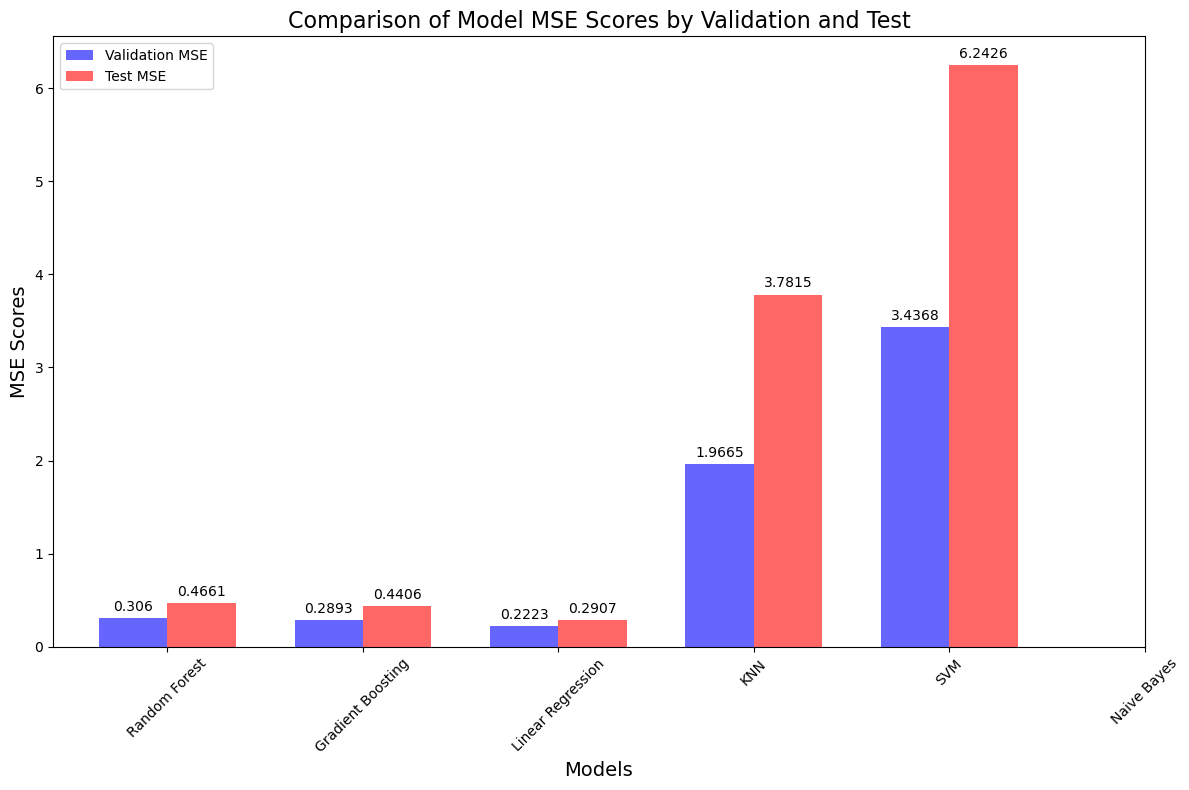

In [25]:
models = ['Random Forest', 'Gradient Boosting', 'Linear Regression', 'KNN', 'SVM', 'Naive Bayes']
validation_mse = [0.3060, 0.2893, 0.2223, 1.9665, 3.4368, np.nan]  # Naive Bayes uses accuracy, so I leave it as NaN
test_mse = [0.4661, 0.4406, 0.2907, 3.7815, 6.2426, np.nan]
index = np.arange(len(models))
bar_width = 0.35

#plot
fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(index - bar_width/2, validation_mse, bar_width, label='Validation MSE', color='b', alpha=0.6)
rects2 = ax.bar(index + bar_width/2, test_mse, bar_width, label='Test MSE', color='r', alpha=0.6)

#Add labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('MSE Scores', fontsize=14)
ax.set_title('Comparison of Model MSE Scores by Validation and Test', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45)
ax.legend()

#Function to add label on top of each bar
def label(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if not np.isnan(height):
            ax.annotate('{}'.format(round(height, 4)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

label(rects1)
label(rects2)

fig.tight_layout()
plt.show()

# Gradient Boosting Improvements

In [26]:
#Here we are improving the best parameters for Gradient Bosting

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
#Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#start GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=42)

#start GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

#fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (MSE): ", -grid_search.best_score_)



Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimato

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END learning_rate=0.01, max_dept

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3

[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.05, max_dep

[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=

Best parameters found:  {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score (MSE):  0.2938404694524957


In [28]:
from sklearn.model_selection import cross_val_score

#Cross-validation to select the best model
best_gb_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_gb_model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

print("Cross-validation MSE scores:", -cv_scores)
print("Mean CV MSE:", -cv_scores.mean())
print("Standard deviation in CV MSE:", cv_scores.std())

Cross-validation MSE scores: [0.20129827 0.19537718 0.36783828 0.30553794 0.21103408]
Mean CV MSE: 0.2562171498696889
Standard deviation in CV MSE: 0.06877632150597356


In [29]:
#setting best parameters and retesting using gradient boosting

features = ['Age', 'G', 'GS', 'MP', 'FG%', '3P%', '2P%', 'FT%', 'Defensive_Rating', 'Offensive_Rating', 'TS%', 'Simplified_PER']
X = player_stats[features]
y = player_stats['PTS']  # Target variable for points per game

#Prepare the imputer and scaler
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

#Impute and scale the training data
X_imputed = imputer.fit_transform(X)  # Fit and transform imputer to the entire dataset
X_scaled = scaler.fit_transform(X_imputed)  # Fit and scale the imputed data

#Splitting the data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#Initialize and fit the Gradient Boosting model with best found parameters
model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)
model.fit(X_train, y_train)

#Predict on validation set and calculate MSE
y_pred_val = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_pred_val)
print("Validation MSE:", val_mse)

#Prepare the test data from another DataFrame assuming it is the 2023 season data
test_data = df[df['Season'] == 2023][features]
test_data_imputed = imputer.transform(test_data)
test_data_scaled = scaler.transform(test_data_imputed)
y_test = df[df['Season'] == 2023]['PTS']

#Predict on test data and calculate MSE
y_test_pred = model.predict(test_data_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:", test_mse)

Validation MSE: 0.2815441846632754
Test MSE: 0.42963690176742947


# Example of model usage to predict avg PTS of season 2024-25

In [30]:
tatum_data = player_stats[player_stats['Player'] == 'Jayson Tatum'][[
    'Age', 'G', 'GS', 'MP', 'FG%', '3P%', '2P%', 'FT%', 'Defensive_Rating', 
    'Offensive_Rating', 'TS%', 'Simplified_PER'
]]

tatum_data_imputed = imputer.transform(tatum_data) 
tatum_data_scaled = scaler.transform(tatum_data_imputed)

In [31]:
tatum_pts_lr = lr_model.predict(tatum_data_scaled)
print("Predicted PTS for Jayson Tatum in 2024-25 (Linear Regression):", tatum_pts_lr[0])

tatum_pts_gb = model.predict(tatum_data_scaled)
print("Predicted PTS for Jayson Tatum in 2024-25 (Gradient Boosting):", tatum_pts_gb[0])

Predicted PTS for Jayson Tatum in 2024-25 (Linear Regression): 25.807754287788956
Predicted PTS for Jayson Tatum in 2024-25 (Gradient Boosting): 25.739115589709943


# Conclusion

Across all the models tested, the 2 that stand out the most are Linear Regression and Gradient Boosting. With Linear Regression performing better suggests the relationships between the features (like player stats) and the target (points per game) are linear or close to linear. In future work I would like to predict a different feature other than PTS. 

Even though we preprocessed and handled data before we still had to deal with some missing values which is why we used SimpleImputer.

In future work I would also like to explore more data to develop a model that is able to predict results of TeamA vs TeamB as accurately as possible, but this would require more data including, additional player statistics like minutes-per-game, and data of each individual matches.